Author: Sandijs Vasilevskis, savas20@student.sdu.dk

Date: 28-05-2021

In [73]:
from datetime import datetime
import string
import re
import os
import glob
import json
import gzip

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

from collections import Counter

# Downloading the dataset
For the purposes of this project articles from 2019 until now are used. Note that the articles are sorted by the date they appeared on the front pages of news outlets so the article itself can be somewhat older and there will be article duplicates across time-stamps (one article could have stayed on front page for a bit).
- Article data is described here: http://sciride.org/news.html
- The processed articles are available here: https://news-mine.s3.eu-west-2.amazonaws.com/processed.tar.gz
- With documentation here: http://sciride.org/news.html#datacontent

# Preprocessing Data
- Filtering articles by news outlet domain name, language and dates
- Tagging articles related to COVID-19
- Prepare training and test datasets
- Tokenization of the article description field (from text to sentences to words), remove punctuation and English stopwords
- Normalization of the tokenized text (stemming, lemmatization)

In [33]:
def filter_articles(domain_name='bbc.com', date_from='2019-01-01', date_to='2021-01-01'):
    """This function retrieves the list of file paths from mayor online news outlets dataset.
    These processed articles can be downloaded here: 
        https://news-mine.s3.eu-west-2.amazonaws.com/processed.tar.gz
    N.B.:
        This function can be used assuming that the compressed file from the link above is downloaded and
        extracted under the 'release' folder and ontains all the news domain subfolders. 
        Otherwise the file path in function glob.glob() can be altered.
    Args:   
        domain_name (str): Subfolder name of the specific online news outlet i.e. 'bbc.com'
        date_from (str): Start date string i.e.'2019-01-01'
        date_to (str): End date string i.e.'2021-01-01'
    Returns:
        file_paths (list): File paths from the selected news article domain and corresponding time period.
    """
    date_from = datetime.strptime(date_from, "%Y-%m-%d")
    date_to = datetime.strptime(date_to, "%Y-%m-%d")
    
    file_paths = []
    for file_name in glob.glob(f'release\\{domain_name}\\per_day\\*.gz'):
        dt_string = os.path.basename(file_name).split('.')[0]
        dt_object = datetime.strptime(dt_string, "%Y%m%d")
    
        if date_to >= dt_object >= date_from:            
            file_path = os.path.join(os.getcwd(), file_name)
            file_paths.append(file_path)
            
    return file_paths   
      
filter_articles()[:5]

['C:\\Files\\SDU Data Science [2020]\\SDU [2021]\\DM882 Text Mining\\Project\\release\\bbc.com\\per_day\\20190101.gz',
 'C:\\Files\\SDU Data Science [2020]\\SDU [2021]\\DM882 Text Mining\\Project\\release\\bbc.com\\per_day\\20190102.gz',
 'C:\\Files\\SDU Data Science [2020]\\SDU [2021]\\DM882 Text Mining\\Project\\release\\bbc.com\\per_day\\20190103.gz',
 'C:\\Files\\SDU Data Science [2020]\\SDU [2021]\\DM882 Text Mining\\Project\\release\\bbc.com\\per_day\\20190104.gz',
 'C:\\Files\\SDU Data Science [2020]\\SDU [2021]\\DM882 Text Mining\\Project\\release\\bbc.com\\per_day\\20190105.gz']

### Combine data from all available news outlets

In [ ]:
# Read .json file with domain names and outlet language
file = open('available_outlets.json', 'r', encoding='utf-8')
outlets = json.loads(file.read())

# Filter news outlets written in English only
outlets_en = {}
for k, v in outlets.items():    
    if v['lng'][0] == 'en':        
        outlets_en[k] = {'country': v['country']}
        
# List of domain names to iterate over
domain_names = list(outlets_en.keys())

In [34]:
# Collect all file paths
file_paths = []
for domain_name in domain_names:    
    file_paths.extend(filter_articles(domain_name, date_from='2019-01-01', date_to='2021-01-01'))
    
len(file_paths)

55160

In [35]:
file_paths

['C:\\Files\\SDU Data Science [2020]\\SDU [2021]\\DM882 Text Mining\\Project\\release\\9news.com.au\\per_day\\20190101.gz',
 'C:\\Files\\SDU Data Science [2020]\\SDU [2021]\\DM882 Text Mining\\Project\\release\\9news.com.au\\per_day\\20190102.gz',
 'C:\\Files\\SDU Data Science [2020]\\SDU [2021]\\DM882 Text Mining\\Project\\release\\9news.com.au\\per_day\\20190103.gz',
 'C:\\Files\\SDU Data Science [2020]\\SDU [2021]\\DM882 Text Mining\\Project\\release\\9news.com.au\\per_day\\20190104.gz',
 'C:\\Files\\SDU Data Science [2020]\\SDU [2021]\\DM882 Text Mining\\Project\\release\\9news.com.au\\per_day\\20190105.gz',
 'C:\\Files\\SDU Data Science [2020]\\SDU [2021]\\DM882 Text Mining\\Project\\release\\9news.com.au\\per_day\\20190106.gz',
 'C:\\Files\\SDU Data Science [2020]\\SDU [2021]\\DM882 Text Mining\\Project\\release\\9news.com.au\\per_day\\20190107.gz',
 'C:\\Files\\SDU Data Science [2020]\\SDU [2021]\\DM882 Text Mining\\Project\\release\\9news.com.au\\per_day\\20190108.gz',
 'C:\\Fi

### Tagging articles related to COVID-19 

In [98]:
def tag_covid19(text):
    """This function uses regular expressions to identify if the text is COVID-19 related or not.
     """
    # Note that '-' is replaced with ' ' to shorten the synonym list
    text = text.replace('-', ' ')
    
    # COVID-19 related keywords
    covid19_synonyms_list = ['covid',
                             r'covid(.*?)19',                             
                             'coronavirus disease 19',
                             r'severe acute respiratory syndrome coronavirus(.*?)2',                             
                             r'sars(.*?)cov(.*?)2',                          
                             r'2019(.*?)n(.*?)cov',                     
                             r'n(.*?)cov(.*?)2019',                             
                             'coronavirus 2019',
                             'wuhan pneumonia',
                             'wuhan virus',
                             'wuhan coronavirus',
                             r'coronavirus(.*?)2',
                            'lockdown', 'quarantine', 'pandemic'
                            ]
    # ignore casing
    if re.compile('|'.join(covid19_synonyms_list), re.IGNORECASE).search(text):            
        return True
    else:
        return False
    
tag_covid19('This text is about coronavirus')

False

In [6]:
def get_article_data(file_path):
    """This function reads the relevant information from zipped article files from the file path.
    """
    dt_string = os.path.basename(file_path).split('.')[0]
    dt_object = datetime.strptime(dt_string, "%Y%m%d")
    
    d = json.load(gzip.open(file_path))
    
    article_list = []
    
    for article_id, article_dict in d.items():        
        dct = {'article_id': article_id, 
               'title': article_dict['title'], 
               'description': article_dict['description'], 
               'date': dt_object}
        dct['is_covid_tag'] = any([tag_covid19(article_dict['description']), tag_covid19(article_dict['title'])])
        dct['is_covid'] = article_dict['is_covid']
        article_list.append(dct)
        
    # Remove duplicated articles    
    df = pd.DataFrame(article_list).drop_duplicates()
    return df
    
df = get_article_data(filter_articles()[-1])
df.head()

,article_id,title,description,date,is_covid_tag,is_covid
0,cd06a6b02378991447309a60ed27bc9c,US election 2020: The young people struggling ...,How the pandemic is changing the economic pros...,2020-10-17,False,True
1,e0ddb2d43e898d0cf212baef9963618f,BBC - Travel - The private language of Venice,Although many travellers assume that the “auth...,2020-10-17,False,False
2,6f0b26eaa2adf75b51edb1eb8fa0bbb4,The African lake with explosive power - BBC Fu...,In central Africa is a deep lake that has a da...,2020-10-17,False,False
3,2c5da074e2b70b2e9e1f6e7b0948cb97,Said Benrahma: West Ham sign Algeria winger fr...,West Ham sign Algeria winger Said Benrahma fro...,2020-10-17,False,False
4,336121e33d92e3fddeb2dad94d20098c,Salisbury Novichok-poisoned officer Nick Baile...,"Det Sgt Nick Bailey ""had to admit defeat"" afte...",2020-10-17,False,False


In [8]:
df.loc[df.is_covid==True]

,article_id,title,description,date,is_covid_tag,is_covid
0,cd06a6b02378991447309a60ed27bc9c,US election 2020: The young people struggling ...,How the pandemic is changing the economic pros...,2020-10-17,False,True
15,7732b68f389d2f1417c605160192deca,Covid: Chris Christie 'was wrong' to not wear ...,"Chris Christie says he was ""wrong"" to shun mas...",2020-10-17,True,True
19,c49ded8610fc493e694bd052d815fc12,India Covid-19: Bollywood faces biggest box of...,With barely any new film releases and the pand...,2020-10-17,True,True
22,46bfe007ced228e33bc679b9334ecc6f,Covid-19: Vaccine should be widely available ‘...,"Head of Vaccine Taskforce says she would be ""s...",2020-10-17,True,True
24,18a46284fa9ab47c75e09185b73c306b,Guinea elections: Campaigning during Covid-19 ...,Candidates and their supporters in Guinea's pr...,2020-10-17,True,True
29,7e4834e792ffb4dde3eaee87d7255ebd,Coronavirus: Empty streets in France as curfew...,The overnight curfew in nine cities is aimed a...,2020-10-17,True,True
39,99cfd2b873d80419b9a26b0ac28e2dfd,How did New Zealand become Covid-19 free? - BB...,What has been the strategy behind New Zealand'...,2020-10-17,True,True
45,7a8ddf4fa66c69242199b32736c6ba31,Covid: Confusion over fresh talks in Mancheste...,Downing Street says talks will resume on Sunda...,2020-10-17,True,True
46,33ede0f42a7ef49430218bf196cad5d0,"Climate change action sidelined by Covid-19, s...",More than half of 18 to 24-years-old in the UK...,2020-10-17,True,True
52,ae39f370903d579363febb3c8f8f09a2,Covid-19: Is Sweden getting it right? - BBC News,The BBC's Ros Atkins looks at one country that...,2020-10-17,True,True


In [16]:
df_list = []
for file_path in filter_articles():      
    try:
        df_list.append(get_article_data(file_path))
    except:
        continue
    
df = pd.concat(df_list)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117145 entries, 0 to 67
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   article_id    117145 non-null  object
 1   title         117145 non-null  object
 2   description   117145 non-null  object
 3   is_covid_tag  117145 non-null  bool  
 4   is_covid      117145 non-null  bool  
dtypes: bool(2), object(3)
memory usage: 3.8+ MB


In [18]:
df.is_covid.value_counts()

False    103166
True      13979
Name: is_covid, dtype: int64

In [19]:
df.is_covid_tag.value_counts()

False    114364
True       2781
Name: is_covid_tag, dtype: int64

## Training and Test Datasets

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.description, df.is_covid, test_size=0.2, random_state=42)

### Random under-sampling

Random under-sampling:
False    13
True     13
Name: is_covid, dtype: int64


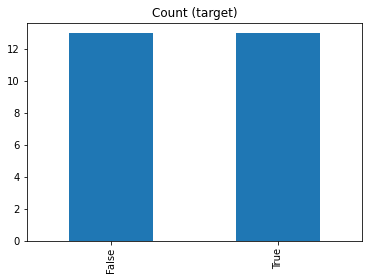

In [10]:
# Class count
count_class_0, count_class_1 = df.is_covid.value_counts()

# Divide by class
df_class_0 = df[df['is_covid'] == 0]
df_class_1 = df[df['is_covid'] == 1]

# Random under-sampling
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.is_covid.value_counts())

df_test_under.is_covid.value_counts().plot(kind='bar', title='Count (target)');

## Tokenization

In [69]:
def tokenize_text(text, remove_stopwords=True):
    """This function will tokenize text and remove stopwords
    """
    word_tokens = []
    # Sentence tokenization
    sentences_nltk = sent_tokenize(text)        
    for sentence in sentences_nltk:
        # Remove punctuation
        sentence = sentence.translate(str.maketrans('', '', string.punctuation)).lower()
        # Word tokenization        
        tokens = [w for w in word_tokenize(sentence)]#if w.isalpha() # leave alphabetic characters only
        
        # Remove stopwords
        if remove_stopwords:
            no_stops = [t for t in tokens if t not in stopwords.words('english')]
            word_tokens.extend(no_stops)            
        else:
            word_tokens.extend(tokens)
    return word_tokens 

In [72]:
text = 'Covid 2019 Rights groups. call the Philippine president\'s comments "repulsive" and "unworthy of his position".'
text = text.translate(str.maketrans('', '', string.punctuation))
tokenize_text(text, remove_stopwords=True)

['covid',
 '2019',
 'rights',
 'groups',
 'call',
 'philippine',
 'presidents',
 'comments',
 'repulsive',
 'unworthy',
 'position']

## Normalization

Stemming follows an algorithm with steps to perform on the words which makes it faster. Whereas, in lemmatization, you used WordNet corpus and a corpus for stop words as well to produce lemma which makes it slower than stemming. You also had to define a parts-of-speech to obtain the correct lemma.

In [47]:
def normalize_text(word_tokens, lemmatize_words=False):
    """This function uses Snowball stemmer or WordNet lemmatizer to normalize words.
    """
    normalized_words = []   
    # Lemmatize words
    if lemmatize_words:        
        wordnet_lemmatizer = WordNetLemmatizer()
        for word in word_tokens:            
            normalized_words.append(wordnet_lemmatizer.lemmatize(word)) 
    # Stem words  
    else:
        snowball = SnowballStemmer('english')
        for word in word_tokens:            
            normalized_words.append(snowball.stem(word))           
    return normalized_words

In [71]:
text = 'Covid-19 Rights groups call the Philippine president\'s comments "repulsive" and "unworthy of his position".'
normalize_text(tokenize_text(text), lemmatize_words=False)

['covid19',
 'right',
 'group',
 'call',
 'philippin',
 'presid',
 'comment',
 'repuls',
 'unworthi',
 'posit']

In [25]:
text = 'Rights groups call the Philippine president\'s comments "repulsive" and "unworthy of his position".'
word_tokens = tokenize_text(text)
stem_snowball = normalize_text(tokenize_text(text), lemmatize_words=False)

for e1, e2 in zip(word_tokens, stem_snowball): 
    print(e1+' ----> '+e2)

rights ----> right
groups ----> group
call ----> call
philippine ----> philippin
president ----> presid
comments ----> comment
repulsive ----> repuls
unworthy ----> unworthi
position ----> posit


In [32]:
def get_word_counts(words):
    """This function returns word count dictionary"""
    return dict(Counter(words))

In [33]:
get_word_counts(word_tokens)

{'rights': 1,
 'groups': 1,
 'call': 1,
 'philippine': 1,
 'president': 1,
 'comments': 1,
 'repulsive': 1,
 'unworthy': 1,
 'position': 1}

In [69]:
fit = True
if fit:
    num_articles = {}
    log_class_priors = {}
    word_counts = {}
    vocab = set()
 
    n = len(X_train)
    num_articles['is_covid'] = sum(1 for label in y_train if label == True)
    num_articles['not_covid'] = sum(1 for label in y_train if label == False)
    log_class_priors['is_covid'] = np.log(num_articles['is_covid'] / n)
    log_class_priors['not_covid'] = np.log(num_articles['not_covid'] / n)
    word_counts['is_covid'] = {}
    word_counts['not_covid'] = {}
 
    for x, y in zip(X_train, y_train):
        c = 'is_covid' if y else 'not_covid'
        tokenized_text = tokenize_text(x)
        normalized_text = normalize_text(tokenized_text)
        counts = get_word_counts(normalized_text)
        
        for word, count in counts.items():
            if word not in vocab:
                vocab.add(word)
            if word not in word_counts[c]:
                word_counts[c][word] = 0.0
 
            word_counts[c][word] += count

In [78]:
def predict(X_test):
    result = []
    for x in X_test:
        tokenized_text = tokenize_text(x)
        normalized_text = normalize_text(tokenized_text)
        counts = get_word_counts(normalized_text)
        is_covid_score = 0
        not_covid_score = 0
        for word, _ in counts.items():
            if word not in vocab: 
                continue
            
            # Laplace smoothing for words not present in training set
            log_w_given_is_covid = np.log( (word_counts['is_covid'].get(word, 0) + 1) / (num_articles['is_covid'] + len(vocab)) )
            log_w_given_not_covid = np.log( (word_counts['not_covid'].get(word, 0) + 1) / (num_articles['not_covid'] + len(vocab)) )
 
            is_covid_score += log_w_given_is_covid
            not_covid_score += log_w_given_not_covid
 
        is_covid_score += log_class_priors['is_covid']
        not_covid_score += log_class_priors['not_covid']
 
        if is_covid_score > not_covid_score:
            result.append(1)
        else:
            result.append(0)
    return result

In [82]:
y_pred = predict(X_test)
y_pred

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [87]:
y_test.astype(int)

46    1
16    0
4     0
9     0
28    0
41    0
58    0
5     0
61    0
12    0
25    0
65    0
47    0
0     1
Name: is_covid, dtype: int32

In [81]:
accuracy_score(y_test, y_pred)

NameError: name 'y_pred' is not defined

In [63]:
log_class_priors['is_covid']

-1.5910887737659039

In [64]:
len(word_counts['is_covid'])

90

In [65]:
log_class_priors['not_covid']

-0.22778393087071197

In [66]:
len(word_counts['not_covid'])

386

In [67]:
len(vocab)

451

In [68]:
vocab

{'accus',
 'action',
 'activ',
 'aesthet',
 'africa',
 'agre',
 'aim',
 'alert',
 'algeria',
 'almost',
 'although',
 'among',
 'an',
 'analysi',
 'angri',
 'anthoni',
 'ardern',
 'area',
 'around',
 'artist',
 'artwork',
 'ash',
 'ashton',
 'assum',
 'atkin',
 'attent',
 'audio',
 'authent',
 'author',
 'avail',
 'avert',
 'back',
 'background',
 'bank',
 'barcelona',
 'bare',
 'battl',
 'battleground',
 'bay',
 'bayern',
 'bbc',
 'begin',
 'behead',
 'behind',
 'benrahma',
 'biden',
 'blanquer',
 'blow',
 'booklet',
 'break',
 'brentford',
 'brisco',
 'brutal',
 'cadiz',
 'call',
 'campaign',
 'canada',
 'candid',
 'cannon',
 'care',
 'cartoon',
 'ceasefir',
 'celebr',
 'celtic',
 'central',
 'challeng',
 'champion',
 'chang',
 'chelsea',
 'chief',
 'chris',
 'christi',
 'church',
 'cinema',
 'citi',
 'civilian',
 'civilis',
 'claim',
 'class',
 'classic',
 'clear',
 'clinch',
 'close',
 'colour',
 'columnist',
 'come',
 'compani',
 'constantin',
 'contest',
 'could',
 'countri',
 'c

In [30]:
# Frequency Analysis
counter = Counter(stem_porter)

# Select top 20 words
counter_dct = dict(counter.most_common(20))
counter.most_common(20)

[('right', 8),
 ('group', 8),
 ('call', 8),
 ('philippin', 8),
 ('presid', 8),
 ('comment', 8),
 ('repuls', 8),
 ('unworthi', 8),
 ('posit', 8),
 ('the', 3),
 ('and', 3),
 ('of', 3),
 ('hi', 3)]

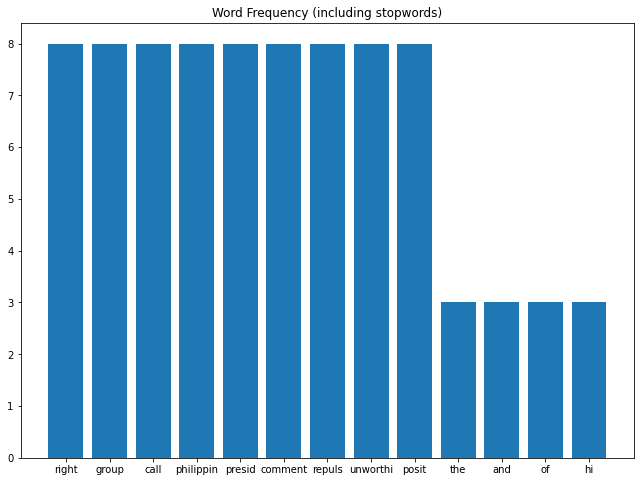

In [31]:
# Plot
fig, ax = plt.subplots(figsize=(11, 8))
plt.bar(counter_dct.keys(), counter_dct.values())
plt.title('Word Frequency (including stopwords)')
plt.show()

# Analysis
Using the titles and descriptions of articles create a suitable normalization pipeline. Describe what normalization steps you are using and what these are achieving in terms of structuring raw text.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [21]:
# Builds a dictionary of features and transforms documents to feature vectors and convert our text documents to a
# matrix of token counts (CountVectorizer)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

# transform a count matrix to a normalized tf-idf representation (tf-idf transformer)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [15]:
X_train_tfidf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [24]:
# Text classifier pipeline
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

# Fitting our train data to the pipeline
text_clf.fit(X_train, y_train)

# Predicting on test data
text_clf.score(X_test, y_test)

0.929617141149857

In [23]:
# Predicting on test data
y_pred = text_clf.predict(X_test)
text_clf.score(X_test, y_test)
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')

Accuracy score: 0.929617141149857


## Naive Bayes Text Classifier
1. Calculate Prior Probabilities for given class labels
2. Calculate Conditional Probabilities with each attribute for each class
3. Multiply same class Conditional Probability
4. Multiply Priorl probability with Step 3 probability
5. See which class has higher probability

## Classifier
Create a classifier that based on news article title and description, makes a determination whether the article is about COVID-19 or not. You should estimate formally the performance of your classifier using accuracy $$(TN + TP)/(TN + TP + FN + FP)$$

Using the classifier, estimate the proportion of articles on COVID-19 in your dataset:
- As proportion of all articles in 2020
- As proportion of all articles in each month of 2020
- As proportion of articles in an outlet (e.g. CNN) in 2020

### Training data

Hint: picking articles with COVID-19 keyword in titles/descriptions would seed your training set of ‘positive’ articles whereas 2019 articles can be taken as
the ‘negative’ set.

## Named Entity Recognisition
Extract the Named Entities - in most cases these will correspond to names of people, places and organizations. You can create your own named entities extractor or use an off-the-shelf one. In either case you should be able to describe in your final report what the algorithm is doing, beyond simply stating the library you used.

Based on the Named Entities analyze what are the most commonly mentioned Named Entities with respect to COVID-19.